# 1. Ground Truth Localization Using ArUco Tags and RealSense D435

Welcome to this tutorial! In this session, we'll learn how to create a ground truth localization system using printed ArUco Tags placed in known locations and a RealSense D435 camera. By the end of this tutorial, you'll understand how to set up the system, detect ArUco Tags, estimate poses, and visualize the results.

**What are ArUco Tags?**
ArUco tags are high-performance fiducial markers designed for robust detection and pose estimation. April tags are another option.They are widely used in robotics, augmented reality, and computer vision applications due to their reliability and efficiency.

Let's get started!

## 2.Prerequisites

Before we begin, ensure you have the following:

### Hardware:
- **RealSense D435 Camera:** For capturing images and depth information.
- **Printed ArUco Tags:** Choose a minimal number (e.g., 4-6) to simplify the tutorial.
- **Measuring Tape or Ruler:** For measuring the positions and orientations of the tags.
- **Mounting Supplies:** To place the tags on walls in your testing area.

### Software:
- **Python 3.x:** Ensure you have Python installed.
- **Jupyter Notebook:** To run the tutorial.
- **Python Libraries:** We'll install these in a moment.
- **RealSense SDK:** We'll install this in the next section. This won't happen in this notebook but in a terminal.


In [ ]:
'''
# 3. Install RealSense sdk on Ubuntu 20.04
# Update System and Install Dependencies
sudo apt-get update && sudo apt-get upgrade
sudo apt-get install git libssl-dev libusb-1.0-0-dev pkg-config libgtk-3-dev
sudo apt-get install libglfw3-dev libgl1-mesa-dev libglu1-mesa-dev

# Clone the Intel RealSense SDK Repository
git clone https://github.com/IntelRealSense/librealsense.git
cd librealsense

# Install UDEV Rules
sudo cp config/99-realsense-libusb.rules /etc/udev/rules.d/
sudo udevadm control --reload-rules && udevadm trigger

# Install librealsense (RealSense SDK)
sudo ./scripts/setup_udev_rules.sh
sudo apt-get install libusb-1.0-0-dev
mkdir build && cd build
cmake ../ -DBUILD_PYTHON_BINDINGS=bool:true
make -j4
sudo make install

# Verify pyrealsense2 Installation
python3 -c "import pyrealsense2 as rs; print('pyrealsense2 is installed successfully')"

# Optional: Install Additional Python Packages
pip install numpy opencv-python

# Verify RealSense Camera Detection
realsense-viewer
'''

In [4]:
# Install necessary libraries
%pip install opencv-contrib-python==4.5.5.64 numpy matplotlib pyrealsense2 ipywidgets scipy

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=f510f7e18d448827f247bf533fa5e5820da3cb9a10fa1a34f5b05a3d74f162b6
  Stored in directory: /home/cairo/.cache/pip/wheels/b4/7f/00/f90ea7c44f8b921477205baa66a7aaf04be398f743ea946fd5
Successfully built fpdf
Note: you may need to restart the kernel to use updated packages.


In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R
import pyrealsense2 as rs
import ipywidgets as widgets
from IPython.display import display
import os
import math


## 3. Generating ArUco Tags

Aruco Tag 0 saved as tags/aruco_tag_0.png
Aruco Tag 1 saved as tags/aruco_tag_1.png
Aruco Tag 2 saved as tags/aruco_tag_2.png
Aruco Tag 3 saved as tags/aruco_tag_3.png


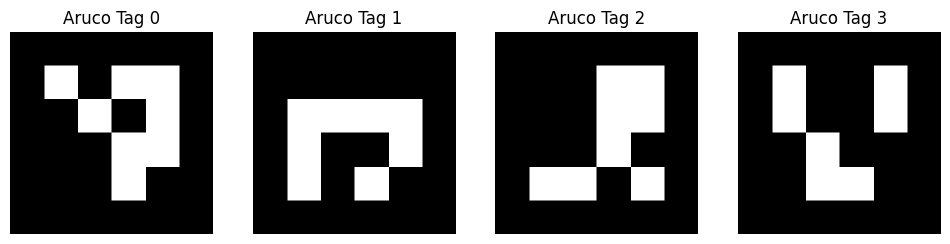

In [3]:
# Create a directory to save the generated tags
tags_dir = 'tags'
os.makedirs(tags_dir, exist_ok=True)

def generate_aruco_tag(tag_id, tag_size=200, dictionary=cv2.aruco.DICT_4X4_50):
    # Initialize the ArUco dictionary
    aruco_dict = cv2.aruco.getPredefinedDictionary(dictionary)
    # Generate the marker image
    tag_image = cv2.aruco.drawMarker(aruco_dict, tag_id, tag_size)
    # Save the tag image as a PNG file
    filename = os.path.join(tags_dir, f'aruco_tag_{tag_id}.png')
    cv2.imwrite(filename, tag_image)
    print(f"Aruco Tag {tag_id} saved as {filename}")
    return tag_image

# Generate 4 distinct ArUco tags with IDs 0, 1, 2, 3
generated_tags = []
for tag_id in range(4):
    tag_image = generate_aruco_tag(tag_id)
    generated_tags.append(tag_image)

# Display the generated tags using Matplotlib
plt.figure(figsize=(12, 3))
for i, tag in enumerate(generated_tags):
    plt.subplot(1, 4, i+1)
    plt.imshow(tag, cmap='gray')
    plt.title(f'Aruco Tag {i}')
    plt.axis('off')
plt.show()

## 3. Placing ArUco Tags

For this tutorial, we'll use a minimal number of ArUco Tags to simplify setup and visualization. Here's how to place them effectively:

1. **Number of Tags:** Use 4 tags placed at different corners of the room to ensure coverage and reduce ambiguity in pose estimation.
2. **Placement Height:** Mount the tags at a consistent height, e.g., 1.5 meters from the floor.
3. **Orientation:** Ensure all tags are facing the camera as direct as possible to avoid distortion. This is not a requirement for the ArUco tag library, but it can help with better pose estimation and thus it is a common practice to put tags on the ceiling.
4. **Measuring Poses:** Use a measuring tape to record the (x, y, z) positions and orientations (rotation) of each tag relative to a fixed coordinate system in the room.


## 4. Camera Calibration

To accurately estimate poses, we need the camera's intrinsic parameters. These include the focal length, optical center, and distortion coefficients.
- **Focal Length**: Determines zoom level, needed for accurate depth and angle interpretation.
- **Optical Center**: The image center, used to align objects in the image with their real-world positions.
- **Distortion Coefficients**: Correct lens distortions to ensure straight lines appear straight in the image.

*The following bit is not needed for this tutorial but it is good to know. It helps you calculate the pose of an object in the image with respect to the camera.*

To find the (x, y) position of a pixel with respect to the camera given that we have the depth value (z) of the pixel:

### Formula:
- $$ x = \frac{(u - c_x) \cdot z}{f_x} $$
- $$ y = \frac{(v - c_y) \cdot z}{f_y} $$

### Where:
- **(u, v)**: Pixel coordinates in the image.
- **(c_x, c_y)**: Optical center (principal point).
- **f_x, f_y**: Focal lengths in the x and y directions.
- **z**: Depth (distance of the pixel from the camera in meters).



### Obtaining Camera Intrinsics

We'll use the RealSense SDK to retrieve the camera intrinsics.


In [4]:
# Initialize RealSense pipeline
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

# Start streaming
pipeline.start(config)

# Get camera intrinsics
profile = pipeline.get_active_profile()
intrinsics = profile.get_stream(rs.stream.color).as_video_stream_profile().get_intrinsics()

# Stop streaming
pipeline.stop()

# Display camera intrinsics
print("Camera Intrinsics:")
print(f"Width: {intrinsics.width}")
print(f"Height: {intrinsics.height}")
print(f"Focal Length: ({intrinsics.fx}, {intrinsics.fy})")
print(f"Principal Point: ({intrinsics.ppx}, {intrinsics.ppy})")
print(f"Distortion Coefficients: {intrinsics.coeffs}")


Camera Intrinsics:
Width: 640
Height: 480
Focal Length: (611.5476684570312, 611.509521484375)
Principal Point: (315.9705810546875, 244.45681762695312)
Distortion Coefficients: [0.0, 0.0, 0.0, 0.0, 0.0]


## 5. Detecting ArUco Tags

We'll use OpenCV's ArUco module to detect and identify tags in images captured by the RealSense camera.

### Capturing an Image

First, let's capture an image using the RealSense D435 camera.


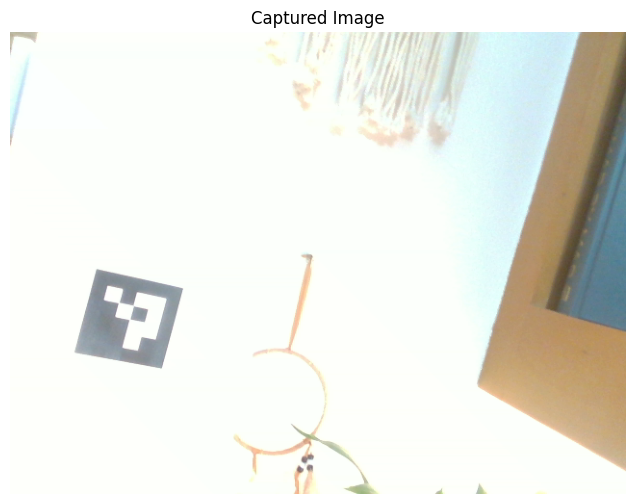

In [34]:
# Initialize RealSense pipeline
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

# Start streaming
pipeline.start(config)

# # Get the sensor once the pipeline is started
# profile = pipeline.get_active_profile()
# sensor = profile.get_device().first_color_sensor()

# # Disable auto exposure
# sensor.set_option(rs.option.enable_auto_exposure, 0)

# # Set manual exposure (higher value means more light)
# sensor.set_option(rs.option.exposure, 3000)  # Example: set exposure to 3000

try:
    while True:
        # Wait for a coherent set of frames
        frames = pipeline.wait_for_frames()

        # Get the color frame
        color_frame = frames.get_color_frame()

        # Convert to numpy array
        color_image = np.asanyarray(color_frame.get_data())

        # Display the image (you can replace this with saving or processing the image)
        cv2.imshow('RealSense Color Image', color_image)

        # Press 'q' to exit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

finally:
    # Stop streaming
    pipeline.stop()

# Display the captured image
plt.figure(figsize=(8,6))
plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))
plt.title('Captured Image')
plt.axis('off')
plt.show()

### Detecting ArUco Tags

Now, let's detect the ArUco tags in the captured image using OpenCV's ArUco module.


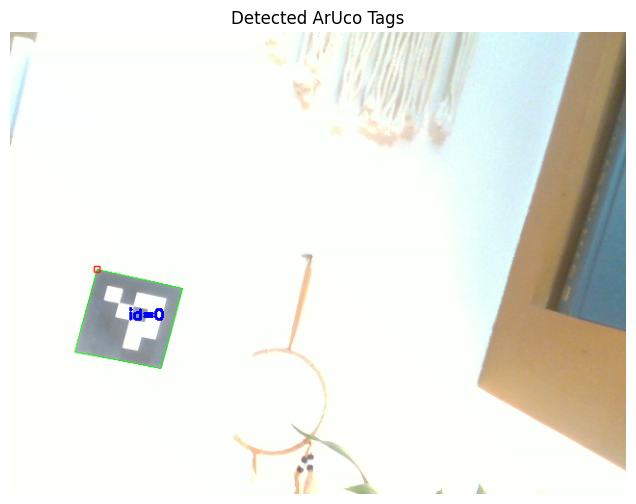

Detected ArUco IDs: [0]
Detected ArUco Corners: (array([[[ 90., 246.],
        [179., 266.],
        [156., 349.],
        [ 67., 332.]]], dtype=float32),)


In [35]:
# Define the ArUco dictionary
aruco_dict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_50)
parameters = cv2.aruco.DetectorParameters_create()

# Detect markers
corners, ids, rejected = cv2.aruco.detectMarkers(color_image, aruco_dict, parameters=parameters)

# Draw detected markers
detected_image = cv2.aruco.drawDetectedMarkers(color_image.copy(), corners, ids)

# Display detected markers
plt.figure(figsize=(8,6))
plt.imshow(cv2.cvtColor(detected_image, cv2.COLOR_BGR2RGB))
plt.title('Detected ArUco Tags')
plt.axis('off')
plt.show()

# Print detected IDs
if ids is not None:
    print("Detected ArUco IDs:", ids.flatten())
    print("Detected ArUco Corners:", corners)
else:
    print("No ArUco tags detected.")

## 6. 2D Pose Estimation

With the detected ArUco tags, we can estimate the camera's 2D pose (position and orientation) relative to the tags using a Homography-based approach.

### Understanding Homography

Homography is a transformation that maps points from one plane to another. Since we're focusing on 2D pose estimation, homography allows us to relate the planar positions of the ArUco tags in the world to their image projections.

### Preparing 2D Points of Tags


In [36]:
# Define tag size in meters
tag_size = 0.071  # 7.1 cm

# Define the 3D coordinates of the tag corners in the tag's coordinate system
# Order: top-left, top-right, bottom-right, bottom-left
obj_points_2D = np.array([
    [-tag_size/2, tag_size/2],
    [ tag_size/2, tag_size/2],
    [ tag_size/2, -tag_size/2],
    [-tag_size/2, -tag_size/2]
], dtype=np.float32)

# Convert 2D object points to 3D by adding Z=0
obj_points_3D = np.hstack((obj_points_2D, np.zeros((obj_points_2D.shape[0], 1), dtype=np.float32)))

# Define world positions for multiple tags
tag_world_positions = {
    0: np.array([1.0, 0.0, 0.0]),        # Tag ID 0 at (0, 0, 0)
    1: np.array([1.0, 0.0, 0.0]),        # Tag ID 1 at (1, 0, 0)
    2: np.array([0.5, 0.866, 0.0])       # Tag ID 2 at (0.5, 0.866, 0)
}

# Collect object and image points from all detected tags
object_points_list = []
image_points_list = []

for i, id in enumerate(ids.flatten()):
    if id in tag_world_positions:
        world_pos = tag_world_positions[id]
        # Define object points for each corner
        for corner in obj_points_2D:
            obj_pt = [world_pos[0] + corner[0], world_pos[1] + corner[1], 0.0]
            object_points_list.append(obj_pt)
        # Append corresponding image points
        image_points_list.extend(corners[i].reshape(-1, 2))

# Convert to NumPy arrays
object_points = np.array(object_points_list, dtype=np.float32)  
image_points = np.array(image_points_list, dtype=np.float32)    

print(f"Object Points shape: {object_points.shape}")
print(f"Image Points shape: {image_points.shape}")


Object Points shape: (4, 3)
Image Points shape: (4, 2)


### Calculating the Camera Pose

Now, let's use the Homography-based method to estimate the camera's 2D pose (rotation and translation) relative to the ArUco tags.


In [41]:
if len(image_points) >= 4 and len(object_points) == len(image_points):
    camera_matrix = np.array([
        [intrinsics.fx, 0, intrinsics.ppx],
        [0, intrinsics.fy, intrinsics.ppy],
        [0, 0, 1]
    ], dtype=np.float32)

    # Assuming no lens distortion; if you have distortion coefficients, replace None with dist_coeffs
    success, rotation_vector, translation_vector = cv2.solvePnP(object_points, image_points, camera_matrix, None)
    
    if success:
        R, _ = cv2.Rodrigues(rotation_vector)
        T = translation_vector

        # Invert Z component if tag is flat on the ground
        T_corrected = T.copy()
        T_corrected[2] = -T_corrected[2]

        print("Estimated Rotation Matrix:\n", R)
        print("Estimated Translation Vector:\n", T_corrected)
    else:
        print("PnP failed.")
else:
    print("Insufficient or mismatched points for pose estimation.")

Estimated Rotation Matrix:
 [[ 0.90808415  0.26738263  0.32231926]
 [ 0.24327103 -0.96327001  0.11371057]
 [ 0.34088471 -0.02484783 -0.93977668]]
Estimated Translation Vector:
 [[-0.15529732]
 [ 0.04378356]
 [-0.49490214]]


## 7. Visualization and Interactive Plots

Visualizing the camera pose and tag positions helps in understanding the localization results. We'll create 2D plots to represent the camera and tags in the environment.


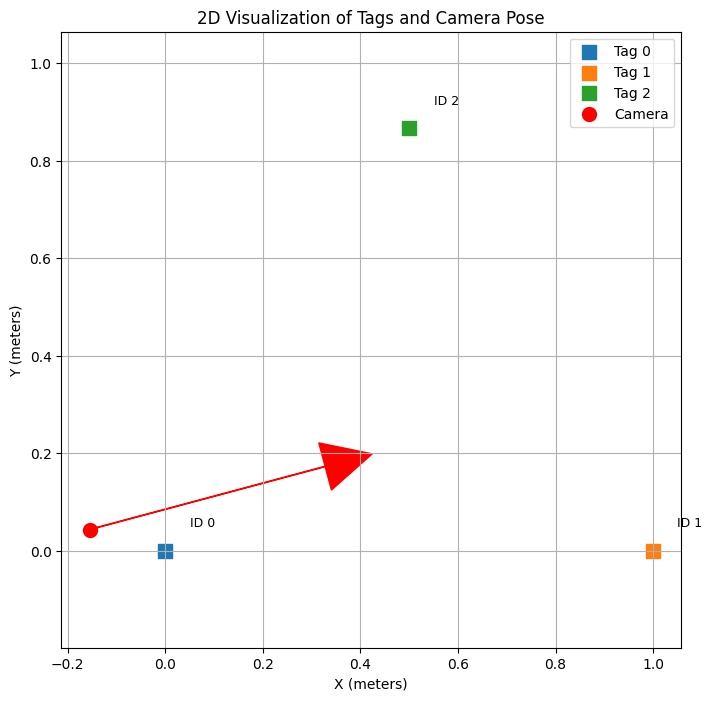

In [43]:
plt.figure(figsize=(8,8))

# Plot tag positions
for id, pos in tag_world_positions.items():
    plt.scatter(pos[0], pos[1], marker='s', s=100, label=f'Tag {id}')
    plt.text(pos[0]+0.05, pos[1]+0.05, f'ID {id}', fontsize=9)

# Plot camera position
# Extract X and Y from the corrected translation vector
camera_position = T_corrected.flatten()[:2]  # 2D position (X, Y)

plt.scatter(camera_position[0], camera_position[1], marker='o', color='red', s=100, label='Camera')

# Draw camera orientation
# Extract rotation angle from rotation matrix
theta = math.atan2(R[1,0], R[0,0])
arrow_length = 0.5  # meters

plt.arrow(camera_position[0], camera_position[1],
            arrow_length * math.cos(theta), arrow_length * math.sin(theta),
            head_width=0.1, head_length=0.1, fc='red', ec='red')

plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')
plt.title('2D Visualization of Tags and Camera Pose')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


## 8. Conclusion

In this tutorial, we've learned how to set up a ground truth 2D localization system using ArUco tags and a RealSense D435 camera. We covered:

- Generating ArUco tags within Python using OpenCV
- Placing ArUco tags on a single plane
- Calibrating the camera and obtaining intrinsic parameters
- Detecting ArUco tags in captured images
- Estimating the camera's 2D pose using Homography
- Visualizing the results in 2D

### Next Steps

- **Enhancements:**
  - **Real-Time Localization:** Implement real-time localization by processing video streams.
  - **Error Metrics:** Explore metrics to evaluate the accuracy of the localization system.
  - **Multiple Planes:** Extend the system to handle multiple planes if needed.

- **Applications:**
  - **Robotics Navigation:** Use the localization system for robot navigation within a predefined area.
  - **Augmented Reality:** Integrate with AR systems to overlay virtual objects based on camera pose.
  - **Motion Tracking Systems:** Track the movement of devices or users within a space.
